In [1]:
#Dependencies
import tensorflow as tf
import os
from os.path import isfile, join
import numpy as np
import shutil
from tensorflow import keras
from pathlib import Path
from IPython.display import display, Audio
import subprocess
import plotly.express as px
import librosa
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd
from tensorflow.keras.layers import Conv1D

In [2]:
data_directory = "/content/drive/MyDrive/vocal_Authenticator/16000_pcm_speeches"
audio_folder = "audio"
noise_folder = "noise"

audio_path = os.path.join(data_directory, audio_folder)
noise_path = os.path.join(data_directory, noise_folder)

In [3]:
audio_path

'/content/drive/MyDrive/vocal Authenticator/16000_pcm_speeches/audio'

In [4]:
noise_path

'/content/drive/MyDrive/vocal Authenticator/16000_pcm_speeches/noise'

In [5]:
voicefile_names = os.listdir(audio_path)
voicefile_names

['Magaret_Tarcher',
 'Benjamin_Netanyau',
 'Jens_Stoltenberg',
 'Julia_Gillard',
 'Nelson_Mandela']

In [6]:
noisefile_names = os.listdir(noise_path)
noisefile_names

['other', '_background_noise_']

In [7]:
#printing How many files in our voice folder
voice_files_count = []
for i in voicefile_names:
    path = os.listdir("/content/drive/MyDrive/vocal_Authenticator/16000_pcm_speeches/audio"+"/"+i)
    len_class = len(path)
    voice_files_count.append(len_class)
voice_files_count

[1500, 1522, 1500, 1501, 1500]

In [8]:
#printing How many files in our noise folder
noise_files_count = []
for i in noisefile_names:
    path = os.listdir("/content/drive/MyDrive/vocal_Authenticator/16000_pcm_speeches/noise"+"/"+i)
    len_class = len(path)
    noise_files_count.append(len_class)
noise_files_count

[2, 4]

In [9]:
#visualize training data in graphical manner
random_x = voicefile_names
random_y = voice_files_count
fig = px.bar(random_x, y = random_y)
fig.show()
#here we have balance dataset

In [10]:
#visualize noise dataset in graphical manner
random_x = noisefile_names
random_y = noise_files_count
fig = px.bar(random_x, y = random_y)
fig.show()

In [11]:
#setting up some hyperparameters
valid_split = 0.1 #testsize
shuffle_seed = 43
sample_rate = 22050
scale = 0.5
batch_size = 128
epochs = 15

In [12]:
noise_paths = []
for subdir in os.listdir(noise_path):
    subdir_path = Path(noise_path)/subdir
    if os.path.isdir(subdir_path):
        noise_paths += [
            os.path.join(subdir_path, filepath)
            for filepath in os.listdir(subdir_path)
            if filepath.endswith(".wav")
        ]
noise_paths

['/content/drive/MyDrive/vocal Authenticator/16000_pcm_speeches/noise/other/exercise_bike.wav',
 '/content/drive/MyDrive/vocal Authenticator/16000_pcm_speeches/noise/other/pink_noise.wav',
 '/content/drive/MyDrive/vocal Authenticator/16000_pcm_speeches/noise/_background_noise_/dude_miaowing.wav',
 '/content/drive/MyDrive/vocal Authenticator/16000_pcm_speeches/noise/_background_noise_/running_tap.wav',
 '/content/drive/MyDrive/vocal Authenticator/16000_pcm_speeches/noise/_background_noise_/doing_the_dishes.wav',
 '/content/drive/MyDrive/vocal Authenticator/16000_pcm_speeches/noise/_background_noise_/10convert.com_Audience-Claps_daSG5fwdA7o.wav']

In [13]:
x, sr = librosa.load('/content/drive/MyDrive/vocal Authenticator/16000_pcm_speeches/noise/other/exercise_bike.wav')
print(x.shape)
print(sr)

(1350648,)
22050


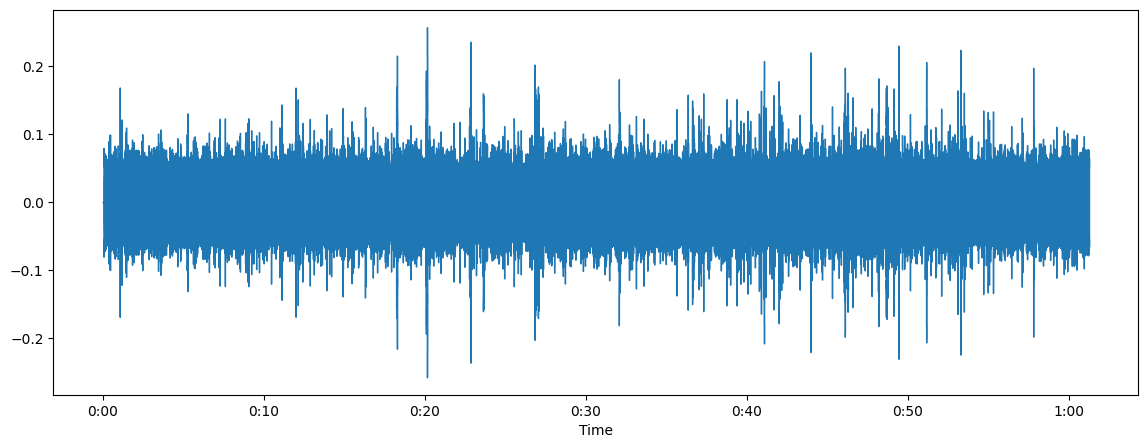

In [14]:
plt.figure(figsize = (14, 5))
librosa.display.waveshow(x, sr = sr)

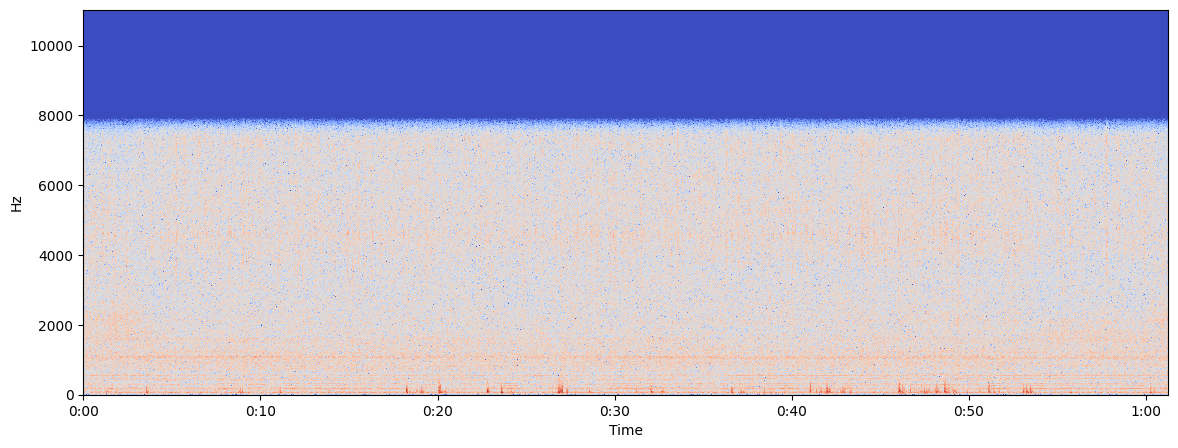

In [15]:
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr = sr, x_axis='time', y_axis='hz')

In [16]:
ipd.Audio('/content/drive/MyDrive/vocal Authenticator/16000_pcm_speeches/noise/other/exercise_bike.wav')

In [17]:
# Resample the audio to the target sampling rate
def resample_audio(audio, original_sr, target_sr=22050):
    audio_resampled = librosa.resample(audio, orig_sr=original_sr, target_sr=target_sr)
    return audio_resampled

# Load the audio file and return the split chunks of size 22050
def load_noise_sample(path, sample_rate=22050):
    sample, sampling_rate = librosa.load(path, sr=None)
    print("Sampling rate of original audio:", sampling_rate)

    if sampling_rate != sample_rate:
        print(f"Resampling from {sampling_rate} Hz to {sample_rate} Hz")
        sample = resample_audio(sample, sampling_rate, target_sr=sample_rate)

    print("Shape of the sample:", sample.shape[0])
    slices = sample.shape[0] // sample_rate
    print("Number of slices:", slices)

    sample_chunks = tf.split(sample[:slices * sample_rate], slices)

    sample_chunks = [tf.reshape(chunk, (sample_rate, 1)) for chunk in sample_chunks]

    return sample_chunks

noises = []

for path in noise_paths:
    sample = load_noise_sample(path)
    if sample:
        noises.extend(sample)

noises = tf.stack(noises[:338])

Sampling rate of original audio: 22050
Shape of the sample: 1350648
Number of slices: 61
Sampling rate of original audio: 22050
Shape of the sample: 1323000
Number of slices: 60
Sampling rate of original audio: 22050
Shape of the sample: 1362816
Number of slices: 61
Sampling rate of original audio: 22050
Shape of the sample: 1348479
Number of slices: 61
Sampling rate of original audio: 22050
Shape of the sample: 2098788
Number of slices: 95
Sampling rate of original audio: 44100
Resampling from 44100 Hz to 22050 Hz
Shape of the sample: 359257
Number of slices: 16


In [18]:
noises

<tf.Tensor: shape=(338, 22050, 1), dtype=float32, numpy=
array([[[ 0.        ],
        [ 0.        ],
        [ 0.        ],
        ...,
        [ 0.00152588],
        [ 0.0274353 ],
        [ 0.03463745]],

       [[ 0.02236938],
        [ 0.01980591],
        [ 0.03091431],
        ...,
        [ 0.02532959],
        [-0.00656128],
        [ 0.00299072]],

       [[ 0.02719116],
        [ 0.01367188],
        [-0.01776123],
        ...,
        [ 0.00491333],
        [ 0.02386475],
        [ 0.01412964]],

       ...,

       [[ 0.02404785],
        [ 0.02218628],
        [ 0.01971436],
        ...,
        [-0.00378418],
        [-0.00109863],
        [-0.00067139]],

       [[-0.00378418],
        [-0.0038147 ],
        [-0.00265503],
        ...,
        [ 0.00421143],
        [ 0.00628662],
        [ 0.00854492]],

       [[ 0.01055908],
        [ 0.00814819],
        [ 0.00454712],
        ...,
        [ 0.00500488],
        [ 0.00854492],
        [ 0.00576782]]], dtype=float3

### DATASET GENERATION

In [19]:
def paths_and_labels_to_dataset(audio_paths, labels):
    path_ds = tf.data.Dataset.from_tensor_slices(audio_paths)
    audio_ds = path_ds.map(lambda x: path_to_audio(x))
    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    return tf.data.Dataset.zip((audio_ds, label_ds))

In [20]:
def path_to_audio(path):
    audio = tf.io.read_file(path)
    audio, _ = tf.audio.decode_wav(audio, 1, sample_rate)
    return audio

### Add noise to dataset

In [21]:
def add_noise(audio, noises=None, scale=0.5):
    if noises is not None:
        tf_rnd = tf.random.uniform(
            (tf.shape(audio)[0],), 0, noises.shape[0], dtype = tf.int32
        )
        noise = tf.gather(noises, tf_rnd, axis=0)
        prop = tf.math.reduce_max(audio, axis=1)/tf.math.reduce_max(noise, axis=1)
        prop = tf.repeat(tf.expand_dims(prop, axis=1), tf.shape(audio)[1], axis=1)

        audio = audio + noise * prop * scale
    return audio

In [22]:
def audio_to_fft(audio):
    audio = tf.squeeze(audio, axis=-1)
    fft = tf.signal.fft(
        tf.cast(tf.complex(real=audio, imag=tf.zeros_like(audio)), tf.complex64)
    )
    fft = tf.expand_dims(fft, axis=-1)
    return tf.math.abs(fft[:, : (audio.shape[1] // 2), :])

In [23]:
class_names = os.listdir(audio_path)
print(class_names,)

audio_paths = []
labels = []
for label, name in enumerate(class_names):
    print("Speaker: ",(name))
    dir_path = Path(audio_path)/name
    speaker_sample_paths = [
        os.path.join(dir_path, filepath)
        for filepath in os.listdir(dir_path)
        if filepath.endswith(".wav")
    ]
    audio_paths += speaker_sample_paths
    labels += [label] * len(speaker_sample_paths)

['Magaret_Tarcher', 'Benjamin_Netanyau', 'Jens_Stoltenberg', 'Julia_Gillard', 'Nelson_Mandela']
Speaker:  Magaret_Tarcher
Speaker:  Benjamin_Netanyau
Speaker:  Jens_Stoltenberg
Speaker:  Julia_Gillard
Speaker:  Nelson_Mandela


In [24]:
#Shuffle to generate random data
rng = np.random.RandomState(shuffle_seed)
rng.shuffle(audio_paths)
rng = np.random.RandomState(shuffle_seed)
rng.shuffle(labels)

In [25]:
#split into training and validation
num_val_samples = int(valid_split * len(audio_paths))
train_audio_paths = audio_paths[: -num_val_samples]
train_labels = labels[:-num_val_samples]

valid_audio_paths = audio_paths[-num_val_samples:]
valid_labels = labels[-num_val_samples:]

In [26]:
#Create datasets, one for training and the other for validation
train_ds = paths_and_labels_to_dataset(train_audio_paths, train_labels)
train_ds = train_ds.shuffle(buffer_size = batch_size * 8, seed = shuffle_seed).batch(batch_size)
valid_ds = paths_and_labels_to_dataset(valid_audio_paths, valid_labels)
valid_ds = valid_ds.shuffle(buffer_size = 32*8, seed=shuffle_seed).batch(32)

### Feature Extraction

In [27]:
# Add noise to the training set
train_ds = train_ds.map(
    lambda x, y: (add_noise(x, noises, scale=scale), y),
    num_parallel_calls=tf.data.experimental.AUTOTUNE,
)

# Transform audio wave to the frequency domain using `audio_to_fft`
train_ds = train_ds.map(
    lambda x, y: (audio_to_fft(x), y), num_parallel_calls=tf.data.experimental.AUTOTUNE
)

train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)

valid_ds = valid_ds.map(
    lambda x, y: (audio_to_fft(x), y), num_parallel_calls=tf.data.experimental.AUTOTUNE
)

valid_ds = valid_ds.prefetch(tf.data.experimental.AUTOTUNE)

### Model

In [28]:
def residual_block(x, filters, conv_num=3, activation='relu'):
    s = keras.layers.Conv1D(filters, 1, padding='same')(x)
    for i in range(conv_num - 1):
        x = keras.layers.Conv1D(filters, 3, padding='same')(x)
        x = keras.layers.Activation(activation)(x)

    x = keras.layers.Conv1D(filters, 3, padding='same')(x)
    x = keras.layers.Add()([x, s])  # Ensure shapes match
    x = keras.layers.Activation(activation)(x)

    return keras.layers.MaxPooling1D(pool_size=2, strides=2)(x)

def build_model(input_shape, num_classes):
    inputs = keras.layers.Input(shape=input_shape, name='input')

    x = residual_block(inputs, 16, 2)
    x = residual_block(inputs, 32, 2)
    x = residual_block(inputs, 64, 3)
    x = residual_block(inputs, 128, 3)
    x = residual_block(inputs, 128, 3)
    x = keras.layers.AveragePooling1D(pool_size=3, strides=3)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(256, activation = 'relu')(x)
    x = keras.layers.Dense(128, activation = 'relu')(x)


    outputs = keras.layers.Dense(num_classes, activation='softmax', name='output')(x)
    return keras.models.Model(inputs=inputs, outputs=outputs)

model = build_model((sample_rate //2 , 1), len(class_names))
model.summary()
model.compile(optimizer="Adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model_save_filename = "model.keras"
earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
mdlcheckpoint_cb = keras.callbacks.ModelCheckpoint(model_save_filename, monitor="val_accuracy", save_best_only=True)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)        │ (None, 11025, 1)       │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_15 (Conv1D)        │ (None, 11025, 128)     │            512 │ input[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_10             │ (None, 11025, 128)     │              0 │ conv1d_15[0][0]        │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_16 (Conv1D)        │ (None, 11025, 128)     │         49,280 │ activation_10[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_11             │ (None, 11025, 128)     │              0 │ conv1d_16[0][0]        │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_17 (Conv1D)        │ (None, 11025, 128)     │         49,280 │ activation_11[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_14 (Conv1D)        │ (None, 11025, 128)     │            256 │ input[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_4 (Add)               │ (None, 11025, 128)     │              0 │ conv1d_17[0][0],       │
│                           │                        │                │ conv1d_14[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_12             │ (None, 11025, 128)     │              0 │ add_4[0][0]            │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_4           │ (None, 5512, 128)      │              0 │ activation_12[0][0]    │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ average_pooling1d         │ (None, 1837, 128)      │              0 │ max_pooling1d_4[0][0]  │
│ (AveragePooling1D)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 235136)         │              0 │ average_pooling1d[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 256)            │     60,195,072 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 128)            │         32,896 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output (Dense)            │ (None, 5)              │            645 │ dense_1[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 60,327,941 (230.13 MB)

 Trainable params: 60,327,941 (230.13 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
model_save_path = "/content/drive/MyDrive/vocal_Authenticator/model.keras"
epochs = 1
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=valid_ds,
    callbacks=[earlystopping_cb, mdlcheckpoint_cb]
)
model.save(model_save_path)

print(f"Model saved to {model_save_path}")

53/53 ━━━━━━━━━━━━━━━━━━━━ 1578s 25s/step - accuracy: 0.4168 - loss: 71.6230 - val_accuracy: 0.8949 - val_loss: 0.3061
Model saved to /content/drive/MyDrive/vocal Authenticator/model.keras


In [30]:
print("Accuracy of model: ", model.evaluate(valid_ds))

24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - accuracy: 0.9108 - loss: 0.2719
Accuracy of model:  [0.306079238653183, 0.894946813583374]


In [31]:
SAMPLES_TO_DISPLAY = 10

test_ds = paths_and_labels_to_dataset(valid_audio_paths, valid_labels)
test_ds = test_ds.shuffle(buffer_size=batch_size * 8, seed=shuffle_seed).batch(batch_size)
test_ds = test_ds.map(lambda x, y: (add_noise(x, noises, scale=scale), y))

for audios, labels in test_ds.take(1):
    ffts = audio_to_fft(audios)
    y_pred = model.predict(ffts)
    rnd = np.random.randint(0, batch_size, SAMPLES_TO_DISPLAY)
    audios = audios.numpy()[rnd, :, :]
    labels = labels.numpy()[rnd]
    y_pred = np.argmax(y_pred, axis=-1)[rnd]

    for index in range(SAMPLES_TO_DISPLAY):
        print(
            "Speaker:\033[{}m {}\033[0m\tPredicted:\033[{}m {}\033[0m".format(
                "92" if labels[index] == y_pred[index] else "91",
                class_names[labels[index]],
                "92" if labels[index] == y_pred[index] else "91",
                class_names[y_pred[index]],
            )
        )
        if labels[index] == y_pred[index]:
            print("Welcome")
        else:
            print("Sorry")

        print(
            "The speaker is {}".format(class_names[y_pred[index]])
            if labels[index] != y_pred[index]
            else "", class_names[y_pred[index]]
        )

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Speaker: Magaret_Tarcher	Predicted: Magaret_Tarcher
Welcome
 Magaret_Tarcher
Speaker: Julia_Gillard	Predicted: Julia_Gillard
Welcome
 Julia_Gillard
Speaker: Nelson_Mandela	Predicted: Nelson_Mandela
Welcome
 Nelson_Mandela
Speaker: Magaret_Tarcher	Predicted: Magaret_Tarcher
Welcome
 Magaret_Tarcher
Speaker: Benjamin_Netanyau	Predicted: Benjamin_Netanyau
Welcome
 Benjamin_Netanyau
Speaker: Benjamin_Netanyau	Predicted: Benjamin_Netanyau
Welcome
 Benjamin_Netanyau
Speaker: Julia_Gillard	Predicted: Julia_Gillard
Welcome
 Julia_Gillard
Speaker: Benjamin_Netanyau	Predicted: Benjamin_Netanyau
Welcome
 Benjamin_Netanyau
Speaker: Benjamin_Netanyau	Predicted: Jens_Stoltenberg
Sorry
The speaker is Jens_Stoltenberg Jens_Stoltenberg
Speaker: Julia_Gillard	Predicted: Julia_Gillard
Welcome
 Julia_Gillard
